In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ISLP import load_data
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix



   Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
0  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
1  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
2  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
3  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
4  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up
            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000 -0.032289 -0.033390 -0.030006 -0.031128 -0.030519  0.841942   
Lag1   -0.032289  1.000000 -0.074853  0.058636 -0.071274 -0.008183 -0.064951   
Lag2   -0.033390 -0.074853  1.000000 -0.075721  0.058382 -0.072499 -0.085513   
Lag3   -0.030006  0.058636 -0.075721  1.000000 -0.075396  0.060657 -0.069288   
Lag4   -0.031128 -0.071274  0.058382 -0.075396  1.000000 -0.075675 -0.061075   
Lag5   -0.030519 -0.008183 -0.072499  0.060657 -0.075675  1.000000 -0.058517   
Volume  0.841942 -0.

<Axes: >

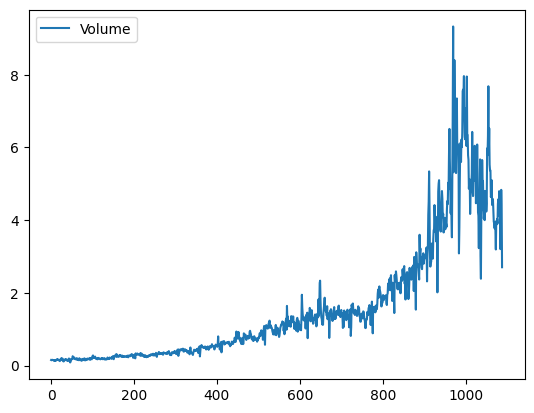

In [21]:
weekly = load_data('Weekly')
print(weekly.head())
# (a)
print(weekly.corr(numeric_only=True, method='pearson'))
weekly.plot (y = 'Volume')

## **(B)** Logistic regression using the full data set

In [ ]:
#(b) logistic regression (Direction as the response variable and five lags+Volum as predictors)
predictors = weekly.columns.drop(['Today', 'Year', 'Direction'])
x = sm.add_constant(weekly[predictors])
weekly['Direction_bin'] = weekly['Direction'].map({'Up': 1, 'Down': 0})
results = sm.GLM(weekly['Direction_bin'], x, family=sm.families.Binomial()).fit()
results.summary()

In [112]:
# (c) confusion_matrix
probs = results.predict(x)
#np.size(probs)
labels = np.array(['Down']*np.size(probs))
labels[probs>0.5] = "Up"
print(confusion_matrix(labels, weekly.Direction))

[[484   0]
 [  0 605]]


In [113]:
(54+557)/np.size(probs), np.mean(labels == weekly.Direction)
print("Error rate is ", 1 - (54+557)/np.size(probs))

Error rate is  0.43893480257116624


## **(D)** Logistic regression using a subset of data 

In [114]:
# (d) fit the logistic regression model using a training data period from 1990 to 2008. 
# the predictor: lag2
train_dataset = weekly[(weekly.Year > 1989) & (weekly.Year < 2009)]
X_train  = sm.add_constant(train_dataset['Lag2'])
y = train_dataset['Direction'].map({'Up':1, 'Down' : 0})
results = sm.GLM (y, X_train).fit()
print(results.summary())

# test dataset
test_dataset = weekly[(weekly.Year > 2008) & (weekly.Year < 2011)]
probs = results.predict(sm.add_constant(test_dataset['Lag2']))
labels = np.array(['Down']* np.size(probs))
labels[probs > 0.5] = "Up"
print(confusion_matrix(labels, test_dataset.Direction))


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  985
Model:                            GLM   Df Residuals:                      983
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.24673
Method:                          IRLS   Log-Likelihood:                -707.41
Date:                Mon, 24 Feb 2025   Deviance:                       242.53
Time:                        12:17:22   Pearson chi2:                     243.
No. Iterations:                     3   Pseudo R-squ. (CS):           0.004216
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5505      0.016     34.726      0.0

In [115]:
print("Error rate is: ", 1 - (9+56)/np.size(probs))

Error rate is:  0.375


### **(E)** Using LDA

In [142]:
# (e) repeat (d) using LDA 
lda = LDA(store_covariance=True)
X_train = train_dataset[['Lag2']]
y = train_dataset['Direction'].map({'Up':1, 'Down' : 0})
LDA_fit = lda.fit(X_train, y)

# test dataset
X_test = test_dataset[['Lag2']]
y_predicted = LDA_fit.predict(X_test)
# convert binary to labels
# create a matrix of the same size as y_predicted and assign all elements as Down
y_predicted_labels = np.array(['Down']* np.size(y_predicted))
# replace 1 with Ups
y_predicted_labels[y_predicted > 0.5] = "Up"
print(confusion_matrix(y_predicted_labels, test_dataset.Direction))


[[ 9  5]
 [34 56]]


In [117]:
print("Error rate is: ", 1 - (9+56)/np.size(y_predicted))

Error rate is:  0.375


### **(F)** Using QDA

In [143]:
# repeat (d) using QDA
qda = QDA(store_covariance=True)
qda_fit = qda.fit(X_train, y)

# test dataset
y_pred_qda = qda_fit.predict(X_test)
# convert binary to labels
# create a matrix of the same size as y_predicted and assign all elements as Down
y_pred_qda_labels = np.array(['Down']* np.size(y_pred_qda))
# replace 1 with Ups
y_pred_qda_labels[y_pred_qda > 0.5] = "Up"
print(confusion_matrix(y_pred_qda_labels, test_dataset.Direction))


[[ 0  0]
 [43 61]]


In [119]:
print("Error rate is: ", 1 - (0+61)/np.size(y_pred_qda))

Error rate is:  0.41346153846153844


## **(G)** KNN with N=1

In [120]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn_fit = knn1.fit(X_train, y)
y_KNN_pred = knn_fit.predict(X_test)
# convert binary to labels
# create a matrix of the same size as y_predicted and assign all elements as Down
y_KNN_pred_labels = np.array(['Down']* np.size(y_KNN_pred))
# replace 1 with Ups
y_KNN_pred_labels[y_KNN_pred > 0.5] = "Up"
print(confusion_matrix(y_KNN_pred_labels, test_dataset.Direction))

[[21 30]
 [22 31]]


In [121]:
print("Error rate is: ", 1 - (31+21)/np.size(y_KNN_pred))

Error rate is:  0.5


## **(H)** naive Bayes


In [135]:
NB = GaussianNB()
NB.fit(X_train, y)
y_NB_pred = NB_fit.predict(X_test)
# convert binary to labels
# create a matrix of the same size as y_predicted and assign all elements as Down
y_NB_pred_labels = np.array(['Down']* np.size(y_NB_pred))
# replace 1 with Ups
y_NB_pred_labels[y_NB_pred > 0.5] = "Up"
confusion_matrix(y_NB_pred_labels, test_dataset.Direction)
cm_df = pd.DataFrame(confusion_matrix(y_NB_pred_labels, test_dataset.Direction), 
                    index = ['Actual Down' , 'Actual Up'],
                     columns = ['Predicted Down','Predicted Up'])
print(cm_df)

             Predicted Down  Predicted Up
Actual Down               0             0
Actual Up                43            61


In [136]:
print("Error rate is: ", 1 - (61+0)/np.size(y_NB_pred))

Error rate is:  0.41346153846153844
